# Cellular automata

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 5

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Zero-dimensional CA

Here's a simple implementation of the 0-D CA I mentioned in the book, with one cell.

In [3]:
n = 10
x = np.zeros(n)
print(x)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


To get the state of the cell in the next time step, we increment the current state mod 2.

In [4]:
x[1] = (x[0] + 1) % 2
x[1]

1.000

Filling in the rest of the array.

In [5]:
for i in range(2, 10):
    x[i] = (x[i-1] + 1) % 2
    
print(x)

[ 0.  1.  0.  1.  0.  1.  0.  1.  0.  1.]


So the behavior of this CA is simple: it blinks.

## One-dimensional CA

Just as we used a 1-D array to show the state of a single cell over time, we'll use a 2-D array to show the state of a 1-D CA over time, with one column per cell and one row per timestep.

In [6]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.int8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


To plot the array I use `plt.imshow`

In [7]:
def plot_ca(array):
    cmap = plt.get_cmap('Blues')
    plt.imshow(array, interpolation='none', cmap=cmap)

Here's what it looks like after we initialize the first row.

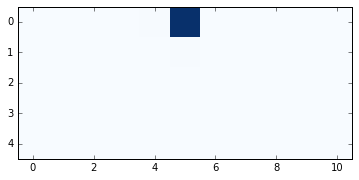

In [8]:
plot_ca(array)

And here's the function that fills in the next row.  The rule for this CA is to take the sum of a cell and its two neighbors mod 2.

In [9]:
def step(array, i):
    rows, cols = array.shape
    for j in range(1, cols):
        array[i, j] = sum(array[i-1, j-1:j+2]) % 2

Here's the second row.

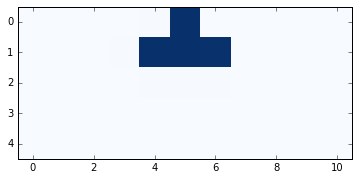

In [10]:
step(array, 1)
plot_ca(array)

And here's what it looks like with the rest of the cells filled in.

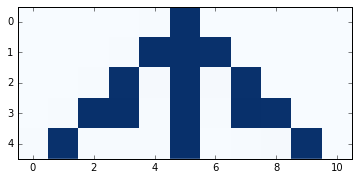

In [11]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

For a simple set of rules, the behavior is more interesting than you might expect.

**Exercise:** Modify this code to increase the number of rows and columns and see what this CA does after more time steps.

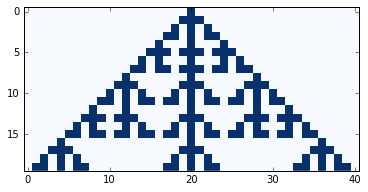

In [18]:
rows2 = 20
cols2 = 41
array2 = np.zeros((rows2, cols2), dtype=np.int8)
array2[0, 20] = 1

for i in range(1, rows2):
    step(array2, i)

plot_ca(array2)

## Cross correlation

We can step the CA through time more quickly using "cross correlation".  To see how it works, the first step is to replace the slice operator with array multiplication.

This window selects the first three elements of an array:

In [19]:
window = np.zeros(cols, dtype=np.int8)
window[:3] = 1
print(window)
print(array[4])
print(window * array[4])

[1 1 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 0 1 0]
[0 1 0 0 0 0 0 0 0 0 0]


Then we can use `sum` and the modulus operator to compute the state of the first cell during the next timestep.

In [20]:
sum(window * array[4]) % 2

1

To compute the state of the next cell, we shift the window to the right.

In [21]:
window = np.roll(window, 1)
print(window)

[0 1 1 1 0 0 0 0 0 0 0]


And repeat the multiply-sum-modulus operations.

In [22]:
sum(window * array[4]) % 2

1

Now we can rewrite `step` using these operations.

In [23]:
def step2(array, i):
    rows, cols = array.shape
    window = np.zeros(cols)
    window[:3] = 1
    for j in range(1, cols):
        array[i, j] = sum(window * array[i-1]) % 2
        window = np.roll(window, 1)

And we can confirm that we get the same result.

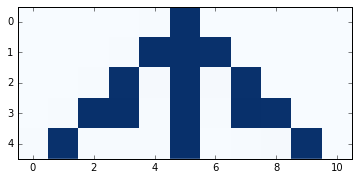

In [24]:
for i in range(1, rows):
    step2(array, i)

plot_ca(array)

That sequence of operations is called a "sliding dot product" or "cross correlation", and NumPy provides a function that computes it.  So we can replace the `for` loop with `np.correlate`.  The parameter `mode='same'` means that the result has the same length as `array[i]`. 

In [25]:
def step3(array, i):
    window = np.array([1, 1, 1])
    array[i] = np.correlate(array[i-1], window, mode='same') % 2

And the result is the same.

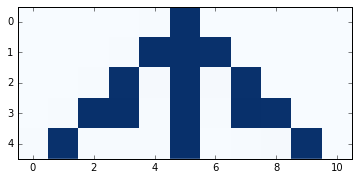

In [26]:
for i in range(1, rows):
    step3(array, i)

plot_ca(array)

So that's good enough for a CA that only depends on the total number of "on" cells, but for more general CAs, we need a table that maps from the configuration of the neighborhood to the future state of the center cell.

The following function makes the table by interpreting the Rule number in binary.

In [27]:
def make_table(rule):
    """Make the table for a given CA rule.
    
    rule: int 0-255
    
    returns: array of 8 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table

Here's what it looks like as an array:

In [28]:
table = make_table(150)
print(table)

[0 1 1 0 1 0 0 1]


If we correlate the row with the window `[4, 2, 1]`, it treats each neighborhood as a binary number between 000 and 111.

In [29]:
window = [4, 2, 1]
corr = np.correlate(array[0], window, mode='same')
print(array[0])
print(corr)

[0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 1 2 4 0 0 0 0]


Now we can use the result from `np.correlate` as an index into the table; the result is the next row of the array.

In [30]:
array[1] = table[corr]
print(array[1])

[0 0 0 0 1 1 1 0 0 0 0]


We can wrap up that code in a function:

In [31]:
def step4(array, i):
    window = np.array([4, 2, 1])
    corr = np.correlate(array[i-1], window, mode='same')
    array[i] = table[corr]

And test it again.

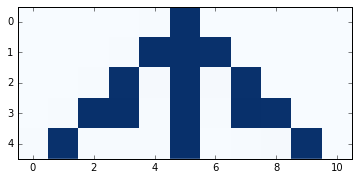

In [32]:
for i in range(1, rows):
    step4(array, i)

plot_ca(array)

How did I know that Rule 150 is the same as the previous CA?  I wrote out the table and converted it to binary.

## The Cell1D object

`Cell1D.py` provides a `Cell1D` class that encapsulates the code from the previous section.

Here's an example that runs a Rule 50 CA for 10 steps.

In [86]:
from Cell1D import Cell1D, Cell1DViewer

In [34]:
rule = 50
n = 10
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

We can display the results:

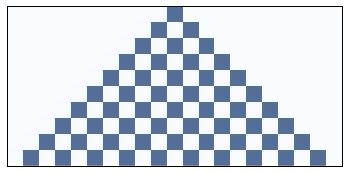

In [35]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-1.pdf')

Here's the Rule 50 table.

In [36]:
print(ca.table)

[0 1 0 0 1 1 0 0]


Another example:

In [37]:
rule = 150
n = 5
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

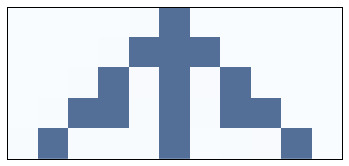

In [38]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-2.pdf')

And one more example showing recursive structure.

In [39]:
rule = 18
n = 64
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

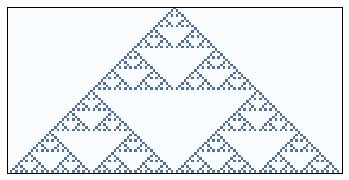

In [40]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-3.pdf')

Rule 30 generates a sequence of bits that is indistinguishable from random:

In [41]:
rule = 30
n = 100
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

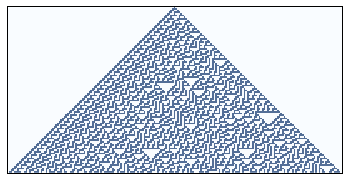

In [42]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-4.pdf')

And Rule 110 is Turing complete!

In [43]:
rule = 110
n = 100
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

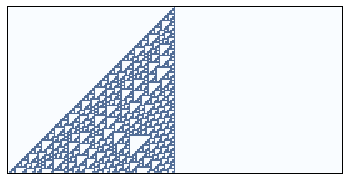

In [44]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-5.pdf')

Heres a longer run that has some spaceships.

In [45]:
rule = 110
n = 600
ca = Cell1D(rule, n)
ca.start_random()
ca.loop(n-1)

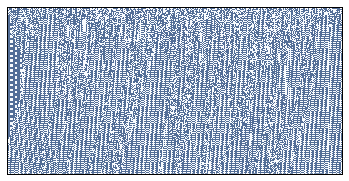

In [46]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-6.pdf')

## Exercises

**Exercise:** This exercise asks you to experiment with Rule 110 and see how
many spaceships you can find.

1. Read the [Wikipedia page about Rule 110](https://en.wikipedia.org/wiki/Rule_110), which describes its background pattern and spaceships.

2. Create a Rule 110 CA with an initial condition that yields the
  stable background pattern.  Note that the CA class provides
`start_string`, which allow you to initialize the state of
the array using a string of `1`s and `0`s.

3. Modify the initial condition by adding different patterns in the
  center of the row and see which ones yield spaceships.  You might
  want to enumerate all possible patterns of $n$ bits, for some
  reasonable value of $n$.  For each spaceship, can you find the
  period and rate of translation?  What is the biggest spaceship you
  can find?

4. What happens when spaceships collide?

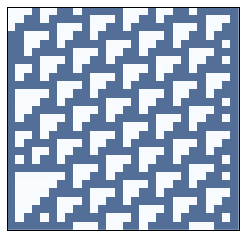

In [85]:
from Cell1D import Wrap1D
rule = 110
n = 2
ca = Cell1D(rule, n, n+1)
ca.start_string("0001001101111100010011011111")
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

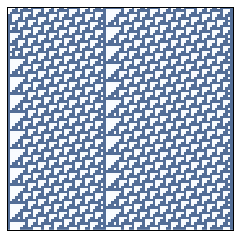

In [90]:
stable = "00010011011111"
start = (stable * 3) + "111" + (stable * 3)
n = len(start)-1
ca = Cell1D(rule, n, n+1)
ca.start_string(start)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw() #Messed up around edges

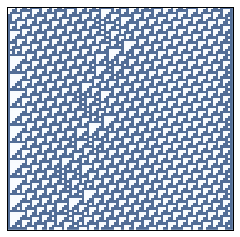

In [91]:
start = (stable * 3) + "1001111" + (stable * 3)
n = len(start)-1
ca = Cell1D(rule, n, n+1)
ca.start_string(start)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

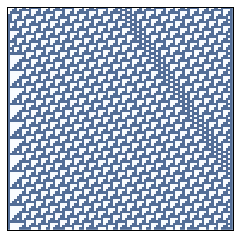

In [92]:
start = (stable * 3) + "0001110111" + (stable * 3)
n = len(start)-1
ca = Cell1D(rule, n, n+1)
ca.start_string(start)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

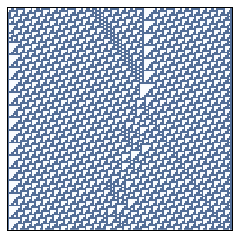

In [93]:
start = (stable * 3) + "0001110111" + (stable * 2) + "111"+ (stable * 3)
n = len(start)-1
ca = Cell1D(rule, n, n+1)
ca.start_string(start)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

In [45]:
# Solution goes here

In [46]:
# Solution goes here

**Exercise:** The goal of this exercise is to implement a Turing machine.

1. Read about Turing machines at http://en.wikipedia.org/wiki/Turing_machine.

2. Write a class called `Turing` that implements a Turing machine.  For the action table, use the rules for a 3-state busy beaver.

3. Write a class named `TuringDrawer` that generates an image that represents the state of the tape and the position and state of the head.  For one example of what that might look like, see http://mathworld.wolfram.com/TuringMachine.html.


In [69]:
#This is pretty clearly inspired by Allan's solution to this problem. 
#I was really stuck, so I worked myself through his implementation, this is the prouct of that.

import numpy
class Turing:
    
    def __init__(self, table, rows=15, cols=None):
        
        self.ROWS = rows
        self.COLS = rows if cols is None else cols
        self.head = numpy.zeros(self.ROWS, dtype=np.int64)
        self.head[0] = self.COLS//2 #middle
        self.table = table
        self.next = 1
        self.tape = numpy.zeros((self.ROWS, self.COLS), dtype=np.int8)
        self.state = "A"
        
    def step(self):
        if self.state == 'HALT':
            raise StopIteration
            
        tape = self.tape
        i = self.next
        tape[i] = tape[i-1]
        head = self.head[i-1]
        symbol = tape[i-1, head]
        print(symbol, self.state, end=': ')
        new_symbol, move, self.state = self.table[symbol, self.state]
        print(new_symbol, move, self.state)
        
        tape[i, head] = new_symbol
        if move == "RIGHT":
            head += 1
        else: # move == 'LEFT'
            head -= 1
        self.head[i] = head
        self.next += 1
        
    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            try:
                self.step()
            except StopIteration:
                break
        
    def getArray(self):
        return self.tape
    
    def getHead(self):
        return self.head

In [70]:
table = {}
table[0, 'A'] = 1, 'RIGHT', 'B' 
table[0, 'B'] = 1, 'LEFT', 'A' 
table[0, 'C'] = 1, 'LEFT', 'B'
table[1, 'A'] = 1, 'LEFT', 'C' 
table[1, 'B'] = 1, 'RIGHT', 'B' 
table[1, 'C'] = 1, 'RIGHT', 'HALT'

table

{(0, 'A'): (1, 'RIGHT', 'B'),
 (0, 'B'): (1, 'LEFT', 'A'),
 (0, 'C'): (1, 'LEFT', 'B'),
 (1, 'A'): (1, 'LEFT', 'C'),
 (1, 'B'): (1, 'RIGHT', 'B'),
 (1, 'C'): (1, 'RIGHT', 'HALT')}

In [77]:
turing = Turing(table, 15)
turing.loop(14)

0 A: 1 RIGHT B
0 B: 1 LEFT A
1 A: 1 LEFT C
0 C: 1 LEFT B
0 B: 1 LEFT A
0 A: 1 RIGHT B
1 B: 1 RIGHT B
1 B: 1 RIGHT B
1 B: 1 RIGHT B
1 B: 1 RIGHT B
0 B: 1 LEFT A
1 A: 1 LEFT C
1 C: 1 RIGHT HALT


In [78]:
%matplotlib notebook
import matplotlib.pyplot as plt
    
def vis(turing):
    array = turing.getArray()
    head = turing.getHead()
    for i in range(array.shape[1]):
        array[i,head[i]]=2
    plt.imshow(array,interpolation="None")

<IPython.core.display.Javascript object>


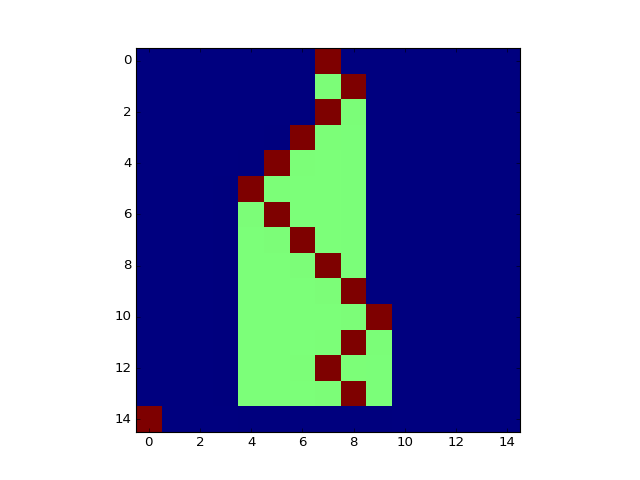

In [79]:
vis(turing)

**Exercise:** This exercise asks you to implement and test several PRNGs.
For testing, you will need to install 
`DieHarder`, which you can download from 
https://www.phy.duke.edu/~rgb/General/dieharder.php, or it
might be available as a package for your operating system.

1. Write a program that implements one of the linear congruential
generators described at http://en.wikipedia.org/wiki/Linear_congruential_generator}.
Test it using `DieHarder`.

2. Read the documentation of Python's `random` module.
What PRNG does it use?  Test it.

3. Implement a Rule 30 CA with a few hundred cells,
run it for as many time steps as you can in a reasonable amount
of time, and output the center column as a sequence of bits.
Test it.


In [82]:
def lcg(seed, modulus=8388608, a=65793, c=4282663):
    return (seed * a + c) % modulus

def lcg_series(seed, n, result=None):
    if result==None:
        result = []
    if n == 0:
        return result
    else:
        result.append(lcg(seed))
        return lcg_series(result[-1],n-1,result)
    
lcg_series(10,100)

[4940593,
 2157912,
 2596479,
 423590,
 6583757,
 6855668,
 3795227,
 8346946,
 6289513,
 178832,
 959415,
 2798558,
 8252165,
 3098924,
 6671955,
 4749946,
 8277409,
 3033032,
 8349935,
 1618198,
 2170941,
 4175460,
 1799051,
 5986226,
 2515673,
 2331904,
 7990823,
 5271118,
 5117301,
 1696668,
 5953731,
 3667178,
 5781521,
 6464056,
 8270687,
 5368710,
 314029,
 4051156,
 2358779,
 6181410,
 1297737,
 7040880,
 800919,
 1910974,
 4538341,
 2850316,
 7791411,
 5140314,
 5841537,
 4062376,
 2358735,
 3286518,
 1013021,
 6482756,
 5474411,
 543890,
 2635705,
 5917152,
 4555527,
 1106734,
 6515285,
 6559868,
 3796387,
 780746,
 68849,
 4216600,
 7391295,
 3760230,
 4267917,
 3081652,
 2757339,
 5850882,
 6529577,
 7349328,
 2477431,
 2858398,
 2659525,
 4436716,
 2357267,
 7365690,
 5240673,
 6926728,
 6591151,
 6789846,
 1690109,
 2236452,
 2596171,
 5325170,
 4590745,
 2948800,
 2955239,
 7165966,
 1359669,
 4869468,
 3474051,
 8117930,
 4579793,
 3804152,
 8346911,
 3986758]

In [84]:
import random
#Mersenne Twisters
[random.random() for x in range(100)]

[0.342222356185256,
 0.9319070283799147,
 0.08724677617848975,
 0.5020002585892119,
 0.07642125974189129,
 0.38157448356936174,
 0.25533938423461244,
 0.09421629938066678,
 0.8737656604551054,
 0.6748777702811821,
 0.7572863721831345,
 0.03977297687897863,
 0.7799789902224443,
 0.9858526026917613,
 0.9429995725481886,
 0.02301727230321937,
 0.42228022330762127,
 0.8464850658147249,
 0.09092932240623741,
 0.8317475929450002,
 0.8832588373063713,
 0.6996911526252216,
 0.3614460911565983,
 0.6016438900608964,
 0.4248490133088201,
 0.372517704691568,
 0.2771185523462695,
 0.43892963320903,
 0.15084634439452704,
 0.5083399962152115,
 0.03360501547562611,
 0.7460318857600737,
 0.7313254303259563,
 0.7511989522409491,
 0.2457564729232954,
 0.6509741724999947,
 0.1252475818881369,
 0.4759296285626078,
 0.18324648758912487,
 0.28260757141186343,
 0.37552928618294557,
 0.9865075900006309,
 0.2372406823812263,
 0.8870255157748919,
 0.40417917885455157,
 0.3893596055979568,
 0.2320520824482426,
 0

In [92]:
ca = Cell1D(30, 10000, 20000)
ca.start_single()
ca.loop(1999)

In [94]:
center = ca.array[:, 10000]

In [100]:
bits=np.split(center,8)

In [101]:
decs=np.packbits(bits)
decs

array([220, 197, 147, ...,   0,   0,   0], dtype=uint8)